In [1]:
import glob
from osgeo import gdal

import pandas as pd
import matplotlib.pyplot as plt

from load_data import *
from forecasts import *
from evaluation_metrics import FSS_plot, save_tiff_files
from visualization import create_animation, create_precipitation_prediction_plots

from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/cc/.pysteps/pystepsrc



In [2]:
event_name = "Côte d'Ivoire_18_06_2018"

metadata = {'accutime': 30.0,
    'cartesian_unit': 'degrees',
    'institution': 'NOAA National Severe Storms Laboratory',
    'projection': '+proj=longlat  +ellps=IAU76',
    'threshold': 0.0125,
    'timestamps': None,
    'transform': None,
    'unit': 'mm/h',
    'x1': -21.4,
    'x2': 30.4,
    'xpixelsize': 0.04,
    'y1': -2.9,
    'y2': 33.1,
    'yorigin': 'upper',
    'ypixelsize': 0.04,
    'zerovalue': 0}

In [3]:
# setups = [{'train_st_ind':16, 'train_ed_ind':24, 'prediction_steps': 24},\
#           {'train_st_ind':0, 'train_ed_ind':24, 'prediction_steps': 24}]
setups = [{'train_st_ind':0, 'train_ed_ind':8, 'prediction_steps': 24}]

In [4]:
# load data
init_IMERG_config_pysteps()
precipitation, times = load_IMERG_data_tiff(data_location='data/'+event_name)

sorted_precipitation, sorted_timestamps = sort_IMERG_data(precipitation, times)


Pysteps configuration file found at: /home/cc/.pysteps/pystepsrc

{'fn_ext': 'nc4', 'fn_pattern': 'PrecipRate_00.00_%Y%m%d-%H%M%S', 'importer': 'netcdf_pysteps', 'importer_kwargs': {}, 'path_fmt': '%Y/%m/%d', 'root_path': '/content/IMERG/Flood_Ghana_032023/', 'timestep': 30}
Shape of the sorted precipitation array (48, 360, 518)


/home/cc/miniconda3/envs/servir/lib/python3.9/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
def steps_nowcast(train_precip, n_ens_members = 20, n_cascade_levels=6):

    R_train, _ = transformation.dB_transform(train_precip, metadata, threshold=0.1, zerovalue=-15.0)

    # Set missing values with the fill value
    R_train[~np.isfinite(R_train)] = -15.0

    # Estimate the motion field
    V = dense_lucaskanade(R_train)

    # The STEPS nowcast
    nowcast_method = nowcasts.get_method("steps")
    R_forcast = nowcast_method(R_train, V, setup['prediction_steps'], n_ens_members=n_ens_members, n_cascade_levels=n_cascade_levels,\
                               precip_thr = -10.0, kmperpixel=10, timestep=30)

    # Back-transform to rain rates
    R_forcast = transformation.dB_transform(R_forcast, threshold=-10.0, inverse=True)[0]

    # the ensemble mean
    R_f_mean = np.nanmean(R_forcast, axis=0)

    return R_f_mean

In [12]:
# STEPS parameters
steps_paras ={'method':'steps', 'n_ens_members':20, 'n_cascade_levels':6}

In [15]:
for setup in setups:

    train_precip = sorted_precipitation[setup['train_st_ind']: setup['train_ed_ind']]

    observed_precip = sorted_precipitation[setup['train_ed_ind']: setup['train_ed_ind'] + setup['prediction_steps']]

    steps_st = time.time()
    R_f_mean = steps_nowcast(train_precip, n_ens_members = steps_paras['n_ens_members'], n_cascade_levels=steps_paras['n_cascade_levels'])
    steps_ed = time.time()

    print(f"{steps_paras['method']} with {setup['train_ed_ind'] - setup['train_st_ind']} training steps takes {(steps_ed - steps_st)/60} mins ")


Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 360x518
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     24
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
----------------------------------------

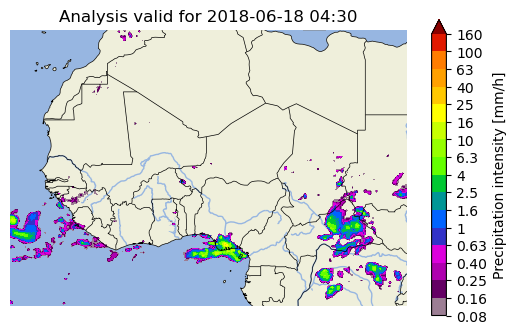

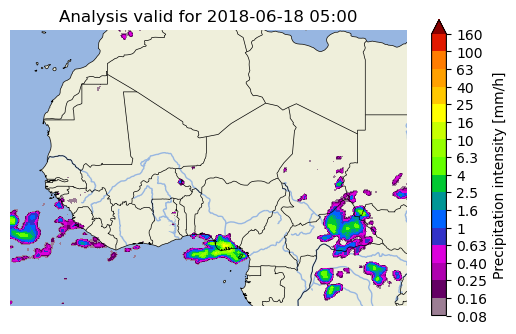

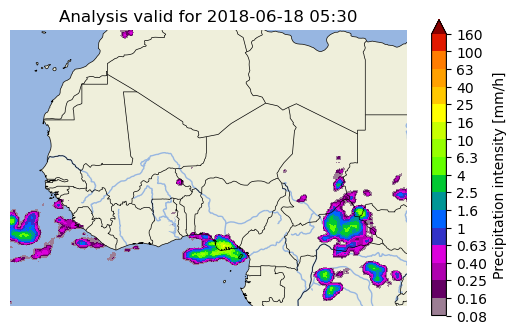

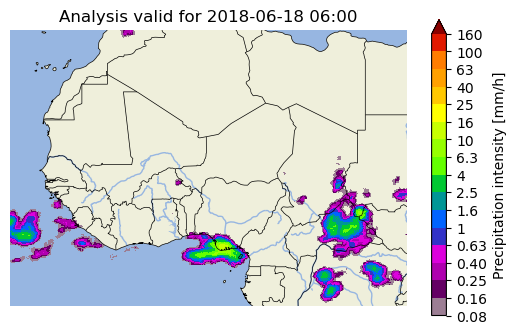

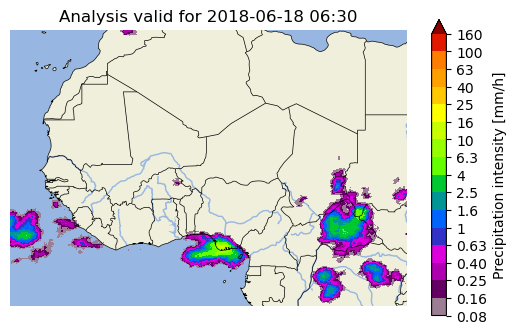

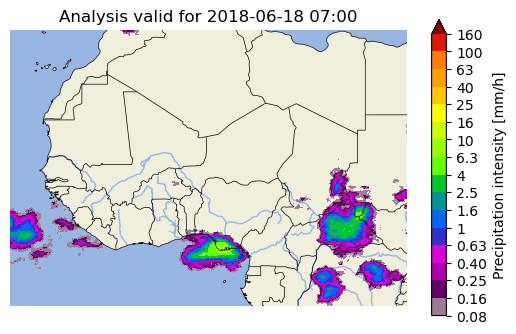

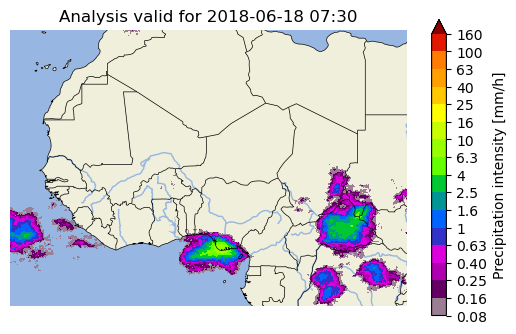

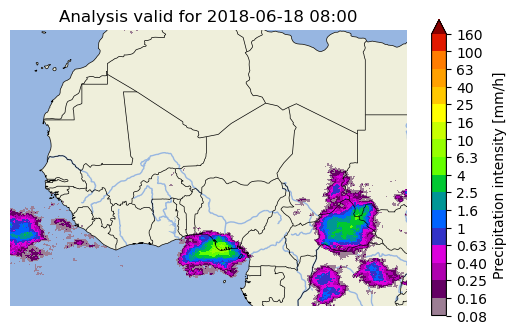

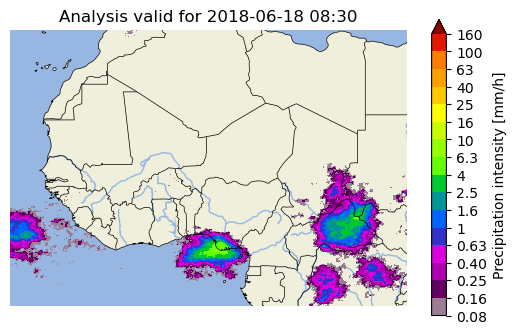

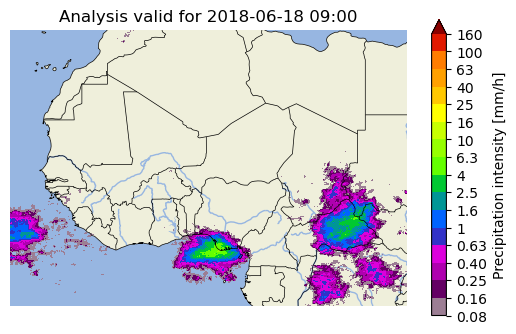

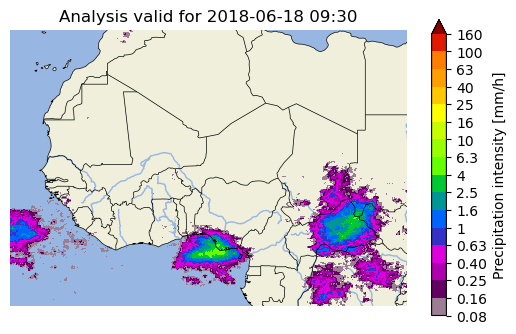

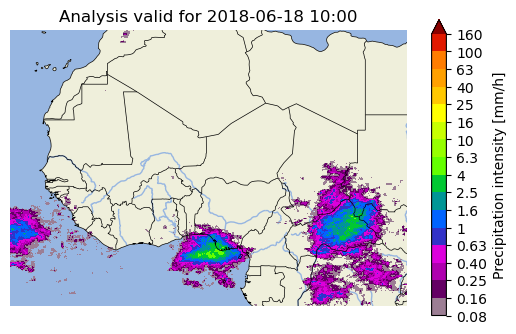

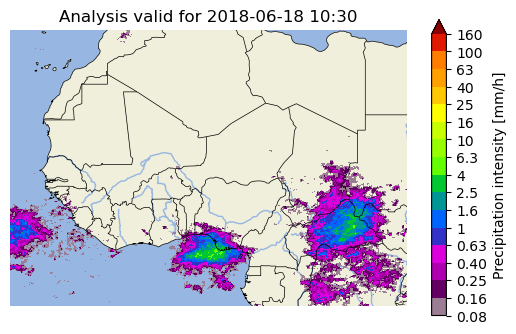

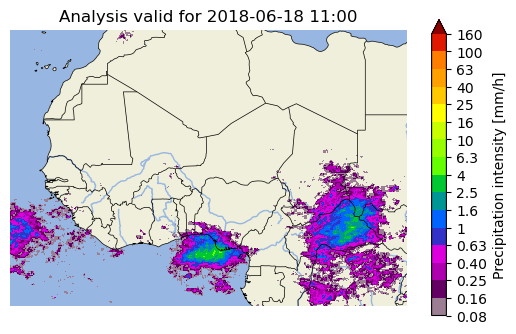

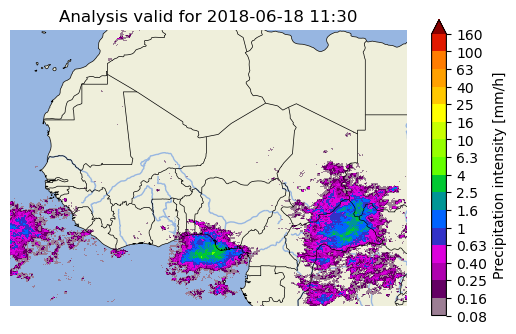

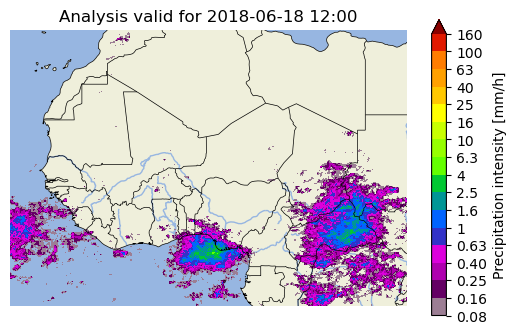

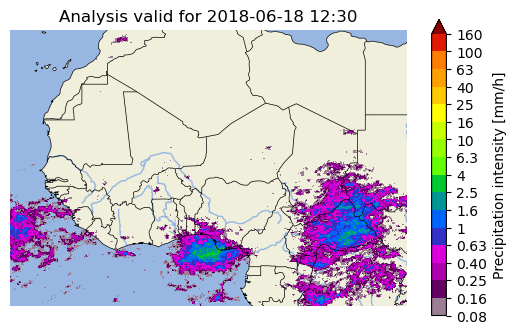

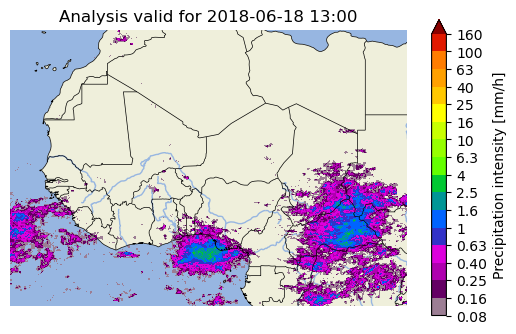

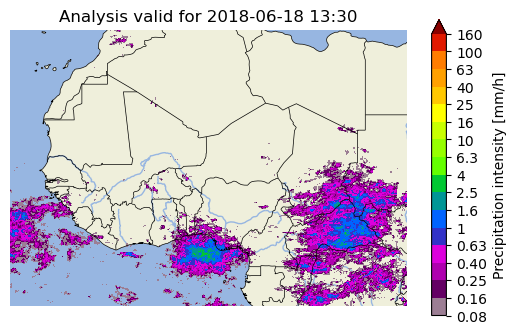

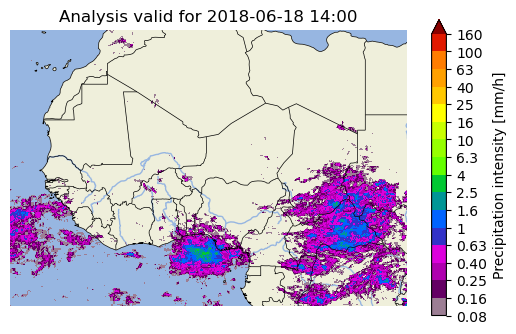

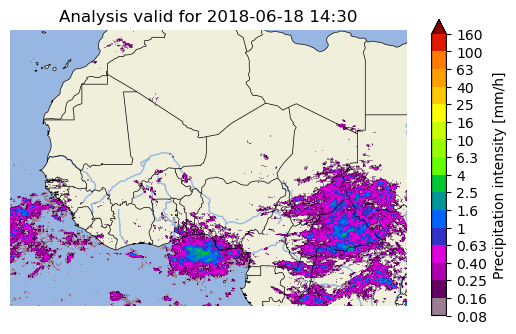

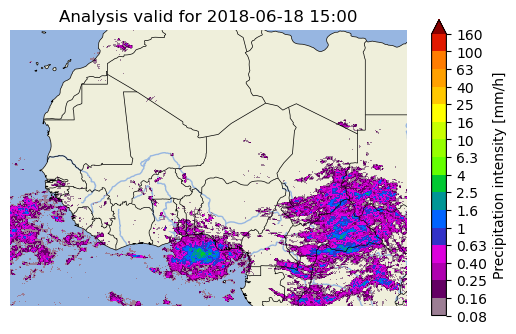

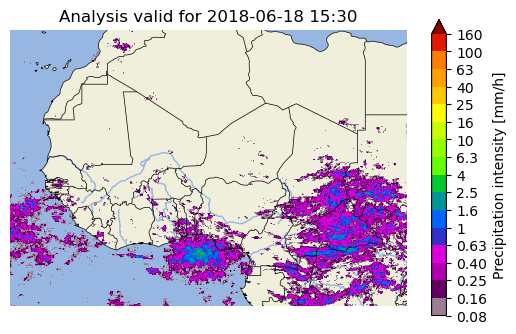

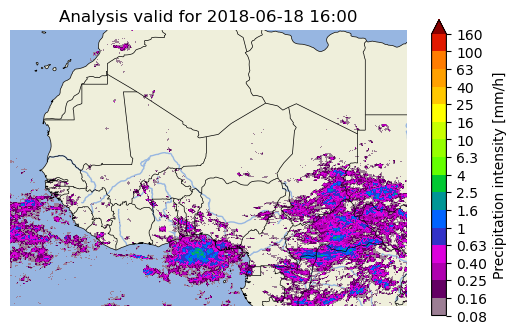

In [16]:
from pysteps.visualization.animations import animate
animate(R_f_mean, \
        # precip_fct  = R_f_mean, \
        timestamps_obs  = sorted_timestamps[setup['train_ed_ind']: setup['train_ed_ind'] + setup['prediction_steps']], \
        timestep_min = 30, geodata=metadata)
        # savefig=True, fig_dpi=100, fig_format='png', path_outputs='steps_nowcasts/'+event_name)

In [ ]:
import imageio
images = []
precipitation_imgs = glob.glob('precipitation_images/*.png') 

In [ ]:
len(precipitation_imgs)

In [ ]:
for filename in precipitation_imgs:
    images.append(imageio.imread(filename))
kargs = { 'duration': 10 }
imageio.mimsave('precipitation_images/movie.gif', images, **kargs)

In [ ]:
len(images)